In [1]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
import scipy as sc
import numpy as np
from numpy import random
from random import randint

from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix


from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings("always")

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
# import redes neuronales artificiales
from sklearn.neural_network import MLPClassifier
# import random forest
from sklearn.ensemble import RandomForestClassifier
# import maquinas de soporte vectorial
from sklearn.svm import SVC




c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from

## Análisis exploratorio de datos 

In [2]:
head_names = ['age', 'job', 'marital', 'education', 'credit', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']
df_bank = pd.read_csv('bank-full.csv', delimiter=';', header=None,names=head_names,skiprows=1)
#df_bank = pd.read_csv('bank.csv', delimiter=';', header=None,names=head_names,skiprows=1)
print("Dimensión data set",df_bank.shape)
tam_muestras = df_bank.shape[0]
tam_caract = df_bank.shape[1]


tam_neg = df_bank["y"].value_counts().values[0]
tam_pos = df_bank["y"].value_counts().values[1]

print("Muestras negativas: "+str(tam_neg))
print("Muestras positivas: "+ str(tam_pos))

Dimensión data set (45211, 17)
Muestras negativas: 39922
Muestras positivas: 5289


### Particionamiento del dataset

Se busca igualar el conjunto de datos, se selecciona todo el conjunto de muestras exitos y aleatoriamente las mismas muestras del conjunto de muestras negativas

In [3]:
dataset_yes = df_bank[df_bank["y"] == "yes"]
dataset_no = df_bank[df_bank["y"] == "no"].iloc[[randint(0, tam_neg) for p in range(0, tam_pos)],:]
df_bank_new = pd.concat([dataset_yes,dataset_no])
print("Nuevo dataset: "+str(df_bank_new.shape))
df_bank_new.head()

Nuevo dataset: (10578, 17)


,age,job,marital,education,credit,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
83,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
86,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
168,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Carácteristicas categóricas

En este caso se debe preprocesar aquellas carácteristicas categorical que el modelo no puede entender y convertirlas a variables númericas, a esto se le conoce como *"One Hot Encode"*. Se resuelve con la librería de sklearn o con pandas creando las variables ficticias conocidas **"Dummy variables"**.

Se debe tener en cuenta que podemos eliminar uno variable "dummy" porque si el resto de variables no son debe ser esa, esto quitará redundancia.

Este caso corresponde a las carácteristicas job,education,contact,month y las variables binarias como default, housing,loan, contact y  y.

In [4]:
#df_bank.dtypes

Se selecciona las variables tipo 'object', en este caso corresponde a variables categoricas. Esto nos permite separar dichas variables para su tratamiento con el "One Hot Encoding" segmentada. 

En la siguiente celda se observa que la variable mes puede ser reemplazado por un valor númerico directamente y así mismo con las variables binarias, a esto se le conoce como "Integer encoding"

In [5]:
obj_df = df_bank_new.select_dtypes(include=['object']).copy()
#obj_df.columns

#for column in obj_df.columns:
#    print(obj_df[column].value_counts(ascending=True))

In [6]:
# Reemplazar el mes y variables binarias por un valor numerico
cat_var = {'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12},
          'housing': {'yes':1,'no':0},
          'credit':{'yes':1,'no':0},
          'loan' : {'yes':1,'no':0},
          'y':{'yes':1,'no':0}
         }
obj_df.replace(cat_var, inplace=True)

#for i in range(df_bank.shape[0]):
#    df_bank.at[i, 'month'] = months[df_bank.at[i, 'month']]

In [7]:
#obj_df.head()

### One hot Encode job

Ahora bien, aún nos falta 5 variables por aplicar los valores númericos con más de 2 categorías. Tenemos 'job' con 12 categorías, 'marital' con 3, 'education' con 4, 'contact' con 3, por último 'poutcome' con 4.

Hay que tener en cuenta que existe una trampa de la variables ficticias creadas y consiste en crear una nueva variable por cada una, llega a ser redundante. Por tanto la solución está eliminar una de las variables categóricas, si hay $d$ número de categorías, use $d-1$ en el modelo, el valor omitido se puede considerar como el valor de referencia y los valores nuevos de las categorías restantes representan el cambio de esta referencia.

Dicho lo anterior se resta una categoría a cada variable y las otras 5 variables de categorías enteras esperamos 26 variables, el DataFrame resultante se guarda en **obj_df**

In [8]:
cols_dummies = ['job', 'marital', 'education', 'contact', 'poutcome']
obj_df = pd.get_dummies(obj_df,prefix=cols_dummies, drop_first=True)
obj_df.columns

Index(['credit', 'housing', 'loan', 'month', 'y', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [9]:
#Nombre de las variables categoricas
cat_vars = cols_dummies + list(cat_var.keys())

Nos disponemos a concatenar las variables tipo enteras con las categóricas.

In [10]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown', 'y']

df_bank_copy = df_bank_new.copy()
df_bank_copy = df_bank_copy.drop(columns=cat_vars)
df_bank_2 = pd.concat([obj_df.T, df_bank_copy.T]).T
df_bank_2 = df_bank_2[index]
Xdb = df_bank_2.drop('y', axis=1)
ydb = df_bank_2['y']

## Missing data

En nuestro análisis exploratorio, debemos lidiar con los valores faltantes. Al parecer en nuestro caso no hay, sin embargo muchas veces esos valores pueden de diferente formas tales como 0, signos de interrogación o números negativos (según su interpretación). Es así que decidimos ir más allá.

In [11]:
#Xdb.info()
#Xdb.isna().sum()

## Imbalanced Classes 

Una vez ya tenemos las variables categoricas listas para entrenar, surge otra cuestión. Contamos con un dataset desbalanceado, la clase positiva (el usuario que se suscribió a la campaña) representa un 13% en comparación de la clase negativa. 

Como primera instancia, vamos a aplicar la técnica de SMOTE para hacer pruebas sintenticas y tratar de mejorar ese porcentaje. No buscamos igualarlo pero si mejorar la situación de desbalanceo al menos un poco.

1    5289
0    5289
Name: y, dtype: int64

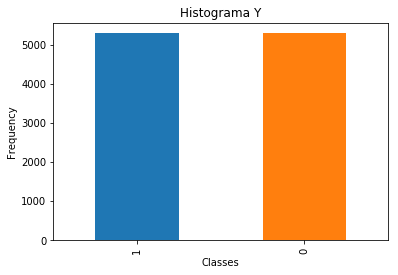

In [12]:
pd.value_counts(ydb).plot.bar()
plt.title('Histograma Y')
plt.xlabel('Classes')
plt.ylabel('Frequency')
ydb.value_counts()


In [13]:
X_train_res, X_val, y_train_res, y_val = train_test_split(Xdb, ydb, test_size=0.2, random_state=0)

X = X_train_res.values
Y = y_train_res.values

print(X.shape, Y.shape)

(8462, 32) (8462,)


In [14]:
#Para calcular el error en los problemas de clasificación
def ErrorClass(Y,Y_lest):
    error = 1 - np.sum(Y_lest == Y)/len(Y)    
    return error

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def recall(matrix):
    return (matrix[0,0]/(matrix[0,0]+matrix(1,0)))

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}


## Naïve Bayes

In [15]:
def naiveBayes(var_smoothing=1e-9):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    Error = np.zeros(Folds)
    ErrorTrain = np.zeros(Folds)
    
    j = 0
   
    # creamos el clasificador
    classifier = GaussianNB(var_smoothing=var_smoothing)  
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)
        
        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        # Entrenamos el clasificador
        classifier.fit(Xtrain, Ytrain)
        
        y_est = classifier.predict(Xtrain)
        y_pred = classifier.predict(Xtest)
        
        
        ErrorTrain[j] = ErrorClass(y_est, Ytrain)
        Error[j] = ErrorClass(y_pred,Ytest)
        
        
        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(y_est.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(y_pred.ravel() == Ytest.ravel())
        j += 1
        
    y_val_pred = classifier.predict(X_val)
    Error_eval = ErrorClass(y_val_pred, y_val)
    mean = round(np.mean(Error),5)
    std = round(np.std(Error),5)
    
    return (mean, std, Error_eval)
    
num = [1e-15,1e-9,1e-7,1e-3,1,5,10,20]
means = np.zeros(len(num))
stds = np.zeros(len(num))
errorVal = np.zeros(len(num))
for i in range(len(num)):
    means[i],stds[i],errorVal[i] = naiveBayes(var_smoothing=num[i])

### Tabla Naive Bayes

In [16]:
randn = np.random.randn
df_types = pd.DataFrame({'Varianza' : pd.Series(num)})
df_types["Error_Prueba"] = means
df_types["Desviación estándar del error"] = stds
df_types["Error en la validación"] = errorVal
df_types.set_index(['Varianza'], inplace=True)
#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)

qgrid_widget.get_changed_df()

c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\qgrid\grid.py:827: DeprecationWarning: QgridWidget._df_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _df_changed(self):


,Error_Prueba,Desviación estándar del error,Error en la validación
Varianza,,,
1.000000e-15,0.28847,0.00447,0.513705
1.000000e-09,0.28847,0.00447,0.513705
1.000000e-07,0.28847,0.00447,0.513705
1.000000e-03,0.28847,0.00447,0.513705
1.000000e+00,0.30690,0.00869,0.513705
5.000000e+00,0.31635,0.00685,0.513705
1.000000e+01,0.31612,0.00594,0.513705
2.000000e+01,0.31635,0.00563,0.513705


## K vecinos más cercanos

In [17]:
def kNN(neighbors=1):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    Error = np.zeros(Folds)
    Error_eval = np.zeros(Folds)
    ErrorTrain = np.zeros(Folds)
    
    j = 0
   
    # creamos el clasificador
    classifier = KNeighborsClassifier(n_neighbors=neighbors)  
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)
        
        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        # Entrenamos el clasificador
        classifier.fit(Xtrain, Ytrain)
        
        y_est = classifier.predict(Xtrain)
        y_pred = classifier.predict(Xtest)
        
        
        ErrorTrain[j] = ErrorClass(y_est, Ytrain)
        Error[j] = ErrorClass(y_pred,Ytest)
        
        
        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(y_est.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(y_pred.ravel() == Ytest.ravel())
        j += 1

    mean = round(np.mean(Error),5)
    std = round(np.std(Error),5)
    y_val_pred = classifier.predict(X_val)
    errorVal = ErrorClass(y_val_pred, y_val)
    
    
    return (mean, std, round(np.mean(errorVal),5))
    
num_vecinos = [1, 2, 4, 5, 10, 20]
means = np.zeros(len(num_vecinos))
stds = np.zeros(len(num_vecinos))
errorVal = np.zeros(len(num_vecinos))
for i in range(len(num_vecinos)):
    means[i],stds[i],errorVal[i] =kNN(num_vecinos[i])

### Tabla K-vecinos

In [18]:
randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de vecinos' : pd.Series(num_vecinos)})
df_types["Error_Prueba"] = means
df_types["Desviación estándar del error"] = stds
df_types["Error en la validación"] = errorVal
df_types.set_index(['Numero de vecinos'], inplace=True)
#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)

qgrid_widget.get_changed_df()

,Error_Prueba,Desviación estándar del error,Error en la validación
Numero de vecinos,,,
1,0.26176,0.00416,0.50000
2,0.28858,0.00766,0.49953
4,0.26117,0.00290,0.49858
5,0.23777,0.00095,0.50709
10,0.25041,0.00355,0.51134
20,0.24746,0.00331,0.51229


## Redes Neuronales Artificiales

In [19]:
def neuralNetwork(hidden=(28,)):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaTest = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    
    #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
    mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=hidden, max_iter=500)
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = preprocessing.scale(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        mlp.fit(Xtrain,Ytrain)

        #Validación con las muestras de entrenamiento
        Ytrain_pred = mlp.predict(Xtrain)

        #Validación con las muestras de test    
        Yest = mlp.predict(Xtest)

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred == Ytrain)
        EficienciaTest[j] = np.mean(Yest == Ytest)
        j += 1
    
    mean = round(np.mean(EficienciaTrain),5)
    std = round(np.std(EficienciaTrain),5)
    
    meanTest = round(np.mean(EficienciaTest),5)
    stdTest = round(np.std(EficienciaTest),5)
    
    errorVal = np.mean(Ytrain_pred == Ytrain)
    
    
    return mean,std,meanTest,stdTest,errorVal

num_layers = [1,1,1,1,1,2,2,2,2,2]
num_neurons_per_layer = [20,24,28,32,36,20,24,28,32,36]
mean = np.zeros(10)
std = np.zeros(10)
meanVal = np.zeros(10)
stdVal = np.zeros(10)
errorVal = 0

for i in range(0,10):
    if(num_layers[i] == 1):
        mean[i], std[i], meanVal[i], stdVal[i], errorVal = neuralNetwork(hidden= (num_neurons_per_layer[i]))
    elif(num_layers[i] == 2):
        mean[i], std[i], meanVal[i], stdVal[i], errorVal = neuralNetwork(hidden= (num_neurons_per_layer[i],num_neurons_per_layer[i]))
    # print('Eficiencia durante el entrenamiento = ' + str(mean[i]) + '+-' + str(std[i]))
    # print('Eficiencia durante la validación = '    + str(meanVal[i]) + '+-' + str(stdVal[i]))
    # print('Error durante la validacion ', errorVal)


c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochasti

c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\alejandro\appdata\local\conda\conda\envs\py3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochasti

In [20]:
df_types = pd.DataFrame({
    'N. de capas ocultas' : pd.Series(num_layers),
    'Neuronas por capa' : pd.Series(num_neurons_per_layer)})
df_types["Eficiencia en el test"] = meanVal
df_types["Intervalo de confianza"] = stdVal
df_types["Error en la validación"] = stdVal
df_types.set_index(['N. de capas ocultas','Neuronas por capa'], inplace=True)
#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget.get_changed_df()

Eficiencia en el test  \
N. de capas ocultas Neuronas por capa                          
1                   20                               0.50343   
                    24                               0.51004   
                    28                               0.50520   
                    32                               0.50236   
                    36                               0.50449   
2                   20                               0.51879   
                    24                               0.55212   
                    28                               0.51323   
                    32                               0.53037   
                    36                               0.52079   

                                       Intervalo de confianza  \
N. de capas ocultas Neuronas por capa                           
1                   20                                0.00808   
                    24                                0.00574   
                    28                                0.00743   
                    32                                0.00191   
                    36                                0.01151   
2                   20                                0.02552   
                    24                                0.06037   
                    28                                0.00973   
                    32                                0.03546   
                    36                                0.02461   

                                       Error en la validación  
N. de capas ocultas Neuronas por capa                          
1                   20                                0.00808  
                    24                                0.00574  
                    28                                0.00743  
                    32                                0.00191  
                    36                                0.01151  
2                   20                                0.02552  
                    24                                0.06037  
                    28                                0.00973  
                    32                                0.03546  
                    36                                0.02461

## Random Forest

In [21]:
def randomForest(num_tree=5, max_var=None):
    #Validamos el modelo
    Folds = 4
    #random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        model = RandomForestClassifier(n_estimators = num_tree, max_features = max_var)
        model.fit(X=Xtrain, y=Ytrain)

        #Validación
        Ytrain_pred = model.predict(Xtrain)#Use el modelo previamente entrenado para hacer predicciones con las mismas muestras de entrenamiento
        Yest =  model.predict(Xtest)#Use el modelo previamente entrenado para hacer predicciones con las muestras de test

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1

    mean = round(np.mean(EficienciaTrain),4)
    std = round(np.std(EficienciaTrain),4)
    
    meanVal = round(np.mean(EficienciaVal),4)
    stdVal = round(np.std(EficienciaVal),4)
    
    return (mean, std, meanVal, stdVal)

# entrenamiento de varios modelos
num_trees = [1,2,3,4,5,10,20,50,100]
var_per_nodes = [1,2,3,4,5,10,15,20]
nums = np.zeros(len(num_trees) * len(var_per_nodes))
vars_per_nodes = np.zeros(len(num_trees) * len(var_per_nodes))
efi_val = np.zeros(len(num_trees) * len(var_per_nodes))
interval = np.zeros(len(num_trees) * len(var_per_nodes))

j = 0
for num in num_trees:
    for var in var_per_nodes:
        mean, std, meanVal, stdVal = randomForest(num,var)
        efi_val[j] = meanVal;
        interval[j] = stdVal;
        vars_per_nodes[j] = var
        nums[j] = num
        j+=1

### Tabla Random Forest

In [22]:
randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de arboles' : pd.Series(nums), 
    'Variables analizadas por nodo' : pd.Series(vars_per_nodes)})
df_types["Eficiencia en validacion"] = efi_val
df_types["Intervalo de confianza"] = interval
df_types['Variables analizadas por nodo'] = vars_per_nodes
df_types.set_index(['Numero de arboles','Variables analizadas por nodo'], inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget.get_changed_df()

Eficiencia en validacion  \
Numero de arboles Variables analizadas por nodo                             
1.0               1.0                                              0.5217   
                  2.0                                              0.6429   
                  3.0                                              0.5130   
                  4.0                                              0.5310   
                  5.0                                              0.5014   
                  10.0                                             0.4944   
                  15.0                                             0.4903   
                  20.0                                             0.4699   
2.0               1.0                                              0.5245   
                  2.0                                              0.5479   
                  3.0                                              0.4975   
                  4.0                                              0.5648   
                  5.0                                              0.5154   
                  10.0                                             0.4917   
                  15.0                                             0.5233   
                  20.0                                             0.4988   
3.0               1.0                                              0.5202   
                  2.0                                              0.4894   
                  3.0                                              0.5015   
                  4.0                                              0.5186   
                  5.0                                              0.5054   
                  10.0                                             0.5025   
                  15.0                                             0.5053   
                  20.0                                             0.4978   
4.0               1.0                                              0.5371   
                  2.0                                              0.5141   
                  3.0                                              0.4967   
                  4.0                                              0.5077   
                  5.0                                              0.5186   
                  10.0                                             0.4799   
...                                                                   ...   
10.0              3.0                                              0.5077   
                  4.0                                              0.5310   
                  5.0                                              0.5073   
                  10.0                                             0.4950   
                  15.0                                             0.4917   
                  20.0                                             0.4979   
20.0              1.0                                              0.5037   
                  2.0                                              0.5025   
                  3.0                                              0.5065   
                  4.0                                              0.5054   
                  5.0                                              0.5061   
                  10.0                                             0.5001   
                  15.0                                             0.5043   
                  20.0                                             0.5077   
50.0              1.0                                              0.5044   
                  2.0                                              0.5050   
                  3.0                                              0.5034   
                  4.0                                              0.5043   
                  5.0                                              0.5034   
                  10.0                       

## Máquinas de Soporte Vectorial con kernel lineal y con kernel RBF.

In [23]:
# lineal kernel and rbf kernel
def SVM(kernel='linear', c=0.001 ,gamma=0):

    if gamma is 0:
        gamma = 'auto'
        
    #Validamos el modelo
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    percentVectors = np.zeros(Folds)
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)

        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        modelo = SVC(C= c,kernel=kernel,gamma=gamma,  decision_function_shape='ovo')
        modelo.fit(Xtrain, Ytrain)
        
        #Calculamos el porcentaje de vector de soporte
        percentVectors[j] = (len(modelo.support_vectors_)/len(Xtrain))

        #Validación
        Ytrain_pred = modelo.predict(Xtrain)
        Yest = modelo.predict(Xtest)

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1

        
    #print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    #print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    #print('% Vectore de soporte = ', modelo.n_support_.sum()/720)
    mean = round(np.mean(EficienciaVal),5)
    std = round(np.std(EficienciaVal),5)
    percent = round(percentVectors.sum()/4, 5)
    return mean,std,percent

#mean,std,percent = SVM(kernel='linear',c=1, gamma=0)

#print('Eficiencia durante el entrenamiento = ' + str(np.mean(mean)) + '+-' + str(np.std(std)))
#print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
#print('% Vectore de soporte = ', percent)

kernels = ['lineal','lineal','lineal','lineal','lineal','lineal','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf']
cs = [0.001,0.01,0.1,1,10,100,0.001,0.001,0.001,0.01,0.01,0.01,0.1,0.1,0.1,1,1,1,10,10,10,100,100,100]
gammas = [0,0,0,0,0,0,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1,0.01,0.1,1]
medias = np.zeros(len(kernels))
stds = np.zeros(len(kernels))
percents = np.zeros(len(kernels))

for i in range(0,len(kernels)):
    if kernels[i] is 'lineal':
        kernel = 'linear'
    elif kernels[i] is 'rbf':
        kernel =  'rbf'
    medias[i],stds[i],percents[i] = SVM(kernel=kernel, c=cs[i], gamma=gammas[i])

## Tabla SVM

In [24]:
import pandas as pd
import qgrid

df_types = pd.DataFrame({
    'Kernel' : pd.Series(kernels),
    'C' : pd.Series(cs),
    'gamma' : pd.Series(gammas)})
df_types["Eficiencia en validacion"] = medias
df_types["Intervalo de confianza"] = stds
df_types["% de Vectores de Soporte"] = percents*100
df_types.set_index(['Kernel','C','gamma'], inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget.get_changed_df()

Eficiencia en validacion  Intervalo de confianza  \
Kernel C       gamma                                                     
lineal 0.001   0.00                    0.80182                 0.00660   
       0.010   0.00                    0.81293                 0.00853   
       0.100   0.00                    0.81269                 0.00855   
       1.000   0.00                    0.81340                 0.00807   
       10.000  0.00                    0.81269                 0.00831   
       100.000 0.00                    0.81293                 0.00830   
rbf    0.001   0.01                    0.50343                 0.00012   
               0.10                    0.50343                 0.00012   
               1.00                    0.50343                 0.00012   
       0.010   0.01                    0.75349                 0.00406   
               0.10                    0.60494                 0.00116   
               1.00                    0.50343                 0.00012   
       0.100   0.01                    0.80737                 0.00507   
               0.10                    0.76424                 0.00611   
               1.00                    0.51016                 0.00093   
       1.000   0.01                    0.82404                 0.00269   
               0.10                    0.81092                 0.00288   
               1.00                    0.69853                 0.00509   
       10.000  0.01                    0.82226                 0.00248   
               0.10                    0.80123                 0.00486   
               1.00                    0.69924                 0.00470   
       100.000 0.01                    0.81505                 0.00484   
               0.10                    0.78575                 0.00413   
               1.00                    0.69783                 0.00335   

                      % de Vectores de Soporte  
Kernel C       gamma                            
lineal 0.001   0.00                     66.253  
       0.010   0.00                     50.362  
       0.100   0.00                     46.695  
       1.000   0.00                     46.222  
       10.000  0.00                     46.163  
       100.000 0.00                     46.179  
rbf    0.001   0.01                     99.315  
               0.10                     99.334  
               1.00                     99.500  
       0.010   0.01                     93.437  
               0.10                     99.279  
               1.00                     99.701  
       0.100   0.01                     64.445  
               0.10                     78.559  
               1.00                     99.720  
       1.000   0.01                     49.287  
               0.10                     61.278  
               1.00                     95.348  
       10.000  0.01                     44.426  
               0.10                     55.838  
               1.00                     92.713  
       100.000 0.01                     42.283  
               0.10                     51.639  
               1.00                     92.453

## 7. Correlación y discrimantes de fisher

## 8. Selección de caracteristicas

In [ ]:
#Feature Selection Function
#Recibe 4 parámetros: 
# 1. el modelo (clf para nuestro caso), 
# 2. el número de características final que se quiere alcanzar
# 3. Si es forward (True), si es Backward False, 
# 4. Si es es flotante (True), sino False
model_g = None
def select_features(modelo, n_features, fwd, fltg):
    
    sfs = SFS(modelo, 
           k_features=n_features, 
           forward=fwd,
           floating=fltg,
           verbose=1,
           scoring='accuracy',
           cv=0)
    
    return sfs

def sequential_selection(model=model, n_features=7, forward=True, floating=True):
    #Para calcular el costo computacional
    tiempo_i = time.time()
    global model_g
    #Implemetamos la metodología de validación cross validation con 10 folds

    Errores = np.ones(10)
    j = 0
    kf = KFold(n_splits=10)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]  

        #Aquí se entrena y se valida el modelo haciendo selección de características con diferentes estrategias

        #Complete el código llamando el método select_features con los parámetros correspondientes para responder el
        #Ejercicio 3.1
        sf = select_features(model,n_features, forward, floating)
        

        #Complete el código para entrenar el modelo con las características seleccionadas. Tenga en cuenta
        #la metodología de validación aplicada para que pase las muestras de entrenamiento correctamente.
        sf = sf.fit(X_train,y_train)
        model_g = sf
        Errores[j] = 1-sf.k_score_
        j+=1
    
    error = round(np.mean(Errores),3)
    ic = round(np.std(Errores),3)
    t = round(time.time()-tiempo_i,2)
    return error,ic,t


In [ ]:
features = [22,3,7,10,3,7,10,3,7,10,3,7,10]
forwards=[None,True,True,True,False,False,False,True,True,True,True,True,True,] 
floatings=[None,False,False,False,False,False,False,True,True,True,True,True,True,]
errors = np.zeros(len(features))
ics = np.zeros(len(features))
timers = np.zeros(len(features))


for i in range(1,len(features)):
    errors[i],ics[i],timers[i] = sequential_selection(clf,features[i],forwards[i],floatings[i])
    

df_types = pd.DataFrame({
    'Técnicas' : pd.Series(['SVM + SFS','SVM + SFS','SVM + SFS','SVM + SBS','SVM + SBS','SVM + SBS','SVM + SFFS','SVM + SFFS','SVM + SFFS','SVM + SFFS','SVM + SFFS','SVM + SFFS']),
    '# de caracteristicas seleccionadas' : pd.Series(features)})
df_types["Error de validación"] = errors
df_types["IC (std)"] = ics
df_types["Tiempo de ejecución"] = timers
df_types.set_index(['Técnicas','# de caracteristicas seleccionadas'], inplace=True)
df_types["Error de validación"][8] = "0.019"
df_types["IC (std)"][8] = "0.002"
df_types["Tiempo de ejecución"][8] = "107.9"
#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)

### Tener en cuenta

In [ ]:
df_bank['job'].describe()

In [ ]:
df_bank[df_bank['pdays'] == -1].shape

In [ ]:
out = df_bank["y"]
out = out.replace("no", 0)
out = out.replace("yes", 1)
x = df_bank["education"]
y = df_bank["job"]

#_ = sns.swarmplot(x='duration', y='age', data=df_bank)
#plt.hist(y)
# Label the axes
plt.title('Age vs housing', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('duration')
plt.scatter(x,y,c=out,cmap="Accent")
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x="housing", y="age", data=df_bank)

In [ ]:

#print("Tipos datos", df_bank.dtypes)
df_bank[df_bank['poutcome'] != 'unknown']
df_success = df_bank[df_bank['y'] == 'yes']
df_no_success = df_bank[df_bank['y'] == 'no']

print("Muestras de exito ",df_success.shape, "Muestras de no éxito",df_no_success.shape)

In [ ]:
df_bank.boxplot('age','job',rot=60)
plt.show()